<a href="https://colab.research.google.com/github/Shamoyeeta/Adversarial-ML/blob/main/attacks/JSMA_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

import numpy as np

import matplotlib
matplotlib.use('Agg')           
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time
import tensorflow.compat.v1 as tf

In [ ]:
def jsma(model, x, y=None, epochs=1, eps=1.0, k=1, clip_min=0.0, clip_max=1.0,
         score_fn=lambda t, o: t * tf.abs(o)):
    """
    Jacobian-based saliency map approach.
    See https://arxiv.org/abs/1511.07528 for details.  During each iteration,
    this method finds the pixel (or two pixels) that has the most influence on
    the result (most salient pixel) and add noise to the pixel.
    :param model: A wrapper that returns the output tensor of the model.
    :param x: The input placeholder a 2D or 4D tensor.
    :param y: The desired class label for each input, either an integer or a
              list of integers.
    :param epochs: Maximum epochs to run.  If it is a floating number in [0,
        1], it is treated as the distortion factor, i.e., gamma in the
        original paper.
    :param eps: The noise added to input per epoch.
    :param k: number of pixels to perturb at a time.  Values other than 1 and
              2 will raise an error.
    :param clip_min: The minimum value in output tensor.
    :param clip_max: The maximum value in output tensor.
    :param score_fn: Function to calculate the saliency score.
    :return: A tensor, contains adversarial samples for each input.
    """
    n = tf.shape(x)[0]

    target = tf.cond(tf.equal(0, tf.rank(y)),
                     lambda: tf.zeros([n], dtype=tf.int32) + y,
                     lambda: y)
    target = tf.stack((tf.range(n), target), axis=1)

    if isinstance(epochs, float):
        tmp = tf.to_float(tf.size(x[0])) * epochs
        epochs = tf.to_int32(tf.floor(tmp))

    if 2 == k:
        _jsma_fn = _jsma2_impl
    else:
        _jsma_fn = _jsma_impl

    return _jsma_fn(model, x, target, epochs=epochs, eps=eps,
                    clip_min=clip_min, clip_max=clip_max, score_fn=score_fn)


def _prod(iterable):
    ret = 1
    for x in iterable:
        ret *= x
    return ret


def _jsma_impl(model, x, yind, epochs, eps, clip_min, clip_max, score_fn):

    def _cond(i, xadv):
        return tf.less(i, epochs)

    def _body(i, xadv):
        ybar = model(xadv)

        dy_dx = tf.gradients(ybar, xadv)[0]

        # gradients of target w.r.t input
        yt = tf.gather_nd(ybar, yind)
        dt_dx = tf.gradients(yt, xadv)[0]

        # gradients of non-targets w.r.t input
        do_dx = dy_dx - dt_dx

        c0 = tf.logical_or(eps < 0, xadv < clip_max)
        c1 = tf.logical_or(eps > 0, xadv > clip_min)
        cond = tf.reduce_all([dt_dx >= 0, do_dx <= 0, c0, c1], axis=0)
        cond = tf.to_float(cond)

        # saliency score for each pixel
        score = cond * score_fn(dt_dx, do_dx)

        shape = score.get_shape().as_list()
        dim = _prod(shape[1:])
        score = tf.reshape(score, [-1, dim])

        # find the pixel with the highest saliency score
        ind = tf.argmax(score, axis=1)
        dx = tf.one_hot(ind, dim, on_value=eps, off_value=0.0)
        dx = tf.reshape(dx, [-1] + shape[1:])

        xadv = tf.stop_gradient(xadv + dx)
        xadv = tf.clip_by_value(xadv, clip_min, clip_max)

        return i+1, xadv

    _, xadv = tf.while_loop(_cond, _body, (0, tf.identity(x)),
                            back_prop=False, name='_jsma_batch')

    return xadv


def _jsma2_impl(model, x, yind, epochs, eps, clip_min, clip_max, score_fn):

    def _cond(k, xadv):
        return tf.less(k, epochs)

    def _body(k, xadv):
        ybar = model(xadv)

        dy_dx = tf.gradients(ybar, xadv)[0]

        # gradients of target w.r.t input
        yt = tf.gather_nd(ybar, yind)
        dt_dx = tf.gradients(yt, xadv)[0]

        # gradients of non-targets w.r.t input
        do_dx = dy_dx - dt_dx

        c0 = tf.logical_or(eps < 0, xadv < clip_max)
        c1 = tf.logical_or(eps > 0, xadv > clip_min)
        cond = tf.reduce_all([dt_dx >= 0, do_dx <= 0, c0, c1], axis=0)
        cond = tf.to_float(cond)

        # saliency score for each pixel
        score = cond * score_fn(dt_dx, do_dx)

        shape = score.get_shape().as_list()
        dim = _prod(shape[1:])
        score = tf.reshape(score, [-1, dim])

        a = tf.expand_dims(score, axis=1)
        b = tf.expand_dims(score, axis=2)
        score2 = tf.reshape(a + b, [-1, dim*dim])
        ij = tf.argmax(score2, axis=1)

        i = tf.to_int32(ij / dim)
        j = tf.to_int32(ij) % dim

        dxi = tf.one_hot(i, dim, on_value=eps, off_value=0.0)
        dxj = tf.one_hot(j, dim, on_value=eps, off_value=0.0)
        dx = tf.reshape(dxi + dxj, [-1] + shape[1:])

        xadv = tf.stop_gradient(xadv + dx)
        xadv = tf.clip_by_value(xadv, clip_min, clip_max)

        return k+1, xadv

    _, xadv = tf.while_loop(_cond, _body, (0, tf.identity(x)),
                            back_prop=False, name='_jsma2_batch')
    return xadv

In [ ]:
img_size = 28
img_chan = 1
n_classes = 10
maxTime = 0;

In [ ]:
print('\nLoading MNIST')

mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = np.reshape(X_train, [-1, img_size, img_size, img_chan])
X_train = X_train.astype(np.float32) / 255
X_test = np.reshape(X_test, [-1, img_size, img_size, img_chan])
X_test = X_test.astype(np.float32) / 255


Loading MNIST
11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
to_categorical = tf.keras.utils.to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
print('\nSpliting data')

ind = np.random.permutation(X_train.shape[0])
X_train, y_train = X_train[ind], y_train[ind]

VALIDATION_SPLIT = 0.1
n = int(X_train.shape[0] * (1-VALIDATION_SPLIT))
X_valid = X_train[n:]
X_train = X_train[:n]
y_valid = y_train[n:]
y_train = y_train[:n]


Spliting data


In [ ]:
print('\nConstruction graph')


def model(x, logits=False, training=False):
    with tf.variable_scope('conv0'):
        z = tf.layers.conv2d(x, filters=32, kernel_size=[3, 3],
                             padding='same', activation=tf.nn.relu)
        z = tf.layers.max_pooling2d(z, pool_size=[2, 2], strides=2)

    with tf.variable_scope('conv1'):
        z = tf.layers.conv2d(z, filters=64, kernel_size=[3, 3],
                             padding='same', activation=tf.nn.relu)
        z = tf.layers.max_pooling2d(z, pool_size=[2, 2], strides=2)

    with tf.variable_scope('flatten'):
        shape = z.get_shape().as_list()
        z = tf.reshape(z, [-1, np.prod(shape[1:])])

    with tf.variable_scope('mlp'):
        z = tf.layers.dense(z, units=128, activation=tf.nn.relu)
        z = tf.layers.dropout(z, rate=0.25, training=training)

    logits_ = tf.layers.dense(z, units=10, name='logits')
    y = tf.nn.softmax(logits_, name='ybar')

    if logits:
        return y, logits_
    return y



Construction graph


In [ ]:
class Dummy:
    pass

In [ ]:
env = Dummy()

In [ ]:
tf.disable_eager_execution()
with tf.variable_scope('model'):
    env.x = tf.placeholder(tf.float32, (None, img_size, img_size, img_chan),name='x')
    env.y = tf.placeholder(tf.float32, (None, n_classes), name='y')
    env.training = tf.placeholder_with_default(False, (), name='mode')

    env.ybar, logits = model(env.x, logits=True, training=env.training)

    with tf.variable_scope('acc'):
        count = tf.equal(tf.argmax(env.y, axis=1), tf.argmax(env.ybar, axis=1))
        env.acc = tf.reduce_mean(tf.cast(count, tf.float32), name='acc')

    with tf.variable_scope('loss'):
        xent = tf.nn.softmax_cross_entropy_with_logits(labels=env.y,
                                                       logits=logits)
        env.loss = tf.reduce_mean(xent, name='loss')

    with tf.variable_scope('train_op'):
        optimizer = tf.train.AdamOptimizer()
        env.train_op = optimizer.minimize(env.loss)

    env.saver = tf.train.Saver()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `tf.layers.dense` is deprecated and will be removed 

In [ ]:
with tf.variable_scope('model', reuse=True):
    env.target = tf.placeholder(tf.int32, (), name='target')
    env.adv_epochs = tf.placeholder_with_default(20, shape=(), name='epochs')
    env.adv_eps = tf.placeholder_with_default(0.2, shape=(), name='eps')
    
    env.x_jsma = jsma(model, env.x, env.target, eps=env.adv_eps,
                      epochs=env.adv_epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `tf.layers.dense` is deprecated and will be removed 

In [ ]:
print('\nInitializing graph')

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())



Initializing graph


In [ ]:
def evaluate(sess, env, X_data, y_data, batch_size=128):
    """
    Evaluate TF model by running env.loss and env.acc.
    """
    print('\nEvaluating')
    
    n_sample = X_data.shape[0]
    n_batch = int((n_sample+batch_size-1) / batch_size)
    loss, acc = 0, 0

    for batch in range(n_batch):
        print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        cnt = end - start
        batch_loss, batch_acc = sess.run(
            [env.loss, env.acc],
            feed_dict={env.x: X_data[start:end],
                       env.y: y_data[start:end]})
        loss += batch_loss * cnt
        acc += batch_acc * cnt
    loss /= n_sample
    acc /= n_sample

    print(' loss: {0:.4f} acc: {1:.4f}'.format(loss, acc))
    return loss, acc

In [ ]:
def train(sess, env, X_data, y_data, X_valid=None, y_valid=None, epochs=1,
          load=False, shuffle=True, batch_size=128, name='model'):
    """
    Train a TF model by running env.train_op.
    """
    if load:
        if not hasattr(env, 'saver'):
            return print('\nError: cannot find saver op')
        print('\nLoading saved model')
        return env.saver.restore(sess, 'model/{}'.format(name))

    print('\nTrain model')
    n_sample = X_data.shape[0]
    n_batch = int((n_sample+batch_size-1) / batch_size)
    for epoch in range(epochs):
        print('\nEpoch {0}/{1}'.format(epoch + 1, epochs))

        if shuffle:
            print('\nShuffling data')
            ind = np.arange(n_sample)
            np.random.shuffle(ind)
            X_data = X_data[ind]
            y_data = y_data[ind]

        for batch in range(n_batch):
            print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
            start = batch * batch_size
            end = min(n_sample, start + batch_size)
            sess.run(env.train_op, feed_dict={env.x: X_data[start:end],
                                              env.y: y_data[start:end],
                                              env.training: True})
        if X_valid is not None:
            evaluate(sess, env, X_valid, y_valid)

    if hasattr(env, 'saver'):
        print('\n Saving model')
        os.makedirs('model', exist_ok=True)
        env.saver.save(sess, 'model/{}'.format(name))

In [ ]:
def predict(sess, env, X_data, batch_size=128):
    """
    Do inference by running env.ybar.
    """
    print('\nPredicting')
    n_classes = env.ybar.get_shape().as_list()[1]

    n_sample = X_data.shape[0]
    n_batch = int((n_sample+batch_size-1) / batch_size)
    yval = np.empty((n_sample, n_classes))

    for batch in range(n_batch):
        print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        y_batch = sess.run(env.ybar, feed_dict={
            env.x: X_data[start:end],
            env.target: np.random.choice(n_classes)})
        yval[start:end] = y_batch
    print()
    return yval

In [ ]:
def make_jsma(sess, env, X_data, epochs=0.2, eps=1.0, batch_size=128):
    """
    Generate JSMA by running env.x_jsma.
    """
    print('\nMaking adversarials via JSMA')
    
    global maxTime

    n_sample = X_data.shape[0]
    n_batch = int((n_sample + batch_size - 1) / batch_size)
    X_adv = np.empty_like(X_data)

    for batch in range(n_batch):
        print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        feed_dict = {
            env.x: X_data[start:end],
            env.target: np.random.choice(n_classes), #random choice of target class
            env.adv_epochs: epochs,
            env.adv_eps: eps}
        tick = time.perf_counter()
        adv = sess.run(env.x_jsma, feed_dict=feed_dict)
        tock = time.perf_counter()
        maxTime = max(maxTime, (tock - tick))
        X_adv[start:end] = adv
    print("Maximum Time " , maxTime)

    return X_adv

In [ ]:
print('\nTraining')

train(sess, env, X_train, y_train, X_valid, y_valid, load=False, epochs=5,
      name='mnist')



Training

Train model

Epoch 1/5

Shuffling data
 batch 422/422
Evaluating
 loss: 0.0741 acc: 0.9772

Epoch 2/5

Shuffling data
 batch 422/422
Evaluating
 loss: 0.0527 acc: 0.9835

Epoch 3/5

Shuffling data
 batch 422/422
Evaluating
 loss: 0.0432 acc: 0.9865

Epoch 4/5

Shuffling data
 batch 422/422
Evaluating
 loss: 0.0396 acc: 0.9895

Epoch 5/5

Shuffling data
 batch 422/422
Evaluating
 loss: 0.0348 acc: 0.9890

 Saving model


In [ ]:
print('\nEvaluating on clean data')

evaluate(sess, env, X_test, y_test)



Evaluating on clean data

Evaluating
 loss: 0.0250 acc: 0.9914


(0.02498405952951871, 0.9914)

In [ ]:
print('\nGenerating adversarial data')

X_adv = make_jsma(sess, env, X_test, epochs=30, eps=3)



Generating adversarial data

Making adversarials via JSMA
Maximum Time  0.28296758600001226


In [ ]:
print('\nEvaluating on adversarial data')

evaluate(sess, env, X_adv, y_test)



Evaluating on adversarial data

Evaluating
 loss: 4.8700 acc: 0.2277


(4.870035866546631, 0.2277)

In [ ]:
print(len(X_adv))

10000


In [ ]:
print('\nRandomly sample adversarial data from each category')

z0 = np.argmax(y_test, axis=1)
z1 = np.argmax(predict(sess, env, X_test), axis=1)
ind = z0 == z1

X_data = X_test[ind]
labels = z0[ind]


Randomly sample adversarial data from each category

Predicting
 batch 79/79


In [ ]:
import pickle

db = {}
db['x_adv'] = X_adv
db['label'] = z0

# Its important to use binary mode
dbfile = open('jsma.pkl', 'ab')
      
# source, destination
pickle.dump(db, dbfile)                     
dbfile.close()

In [ ]:
X_adv = np.empty((10, 10, 28, 28))

In [ ]:
print(z0)
print(z1)
print(labels)
print(len(z0))
print(len(z1))
print(len(labels))

[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]
10000
10000
9914


In [ ]:
for source in np.arange(10):
    print('Source label {0}'.format(source))
    
    X_i = X_data[labels == source]

    for i, xi in enumerate(X_i):
        found = True
        xi = xi[np.newaxis, :]

        for target in np.arange(10):
            print(' [{0}/{1}] {2} -> {3}'
                  .format(i+1, X_i.shape[0], source, target), end='')

            if source == target:
                xadv = xi.copy()
            else:
                feed_dict = {env.x: xi, env.target: target, env.adv_epochs: 30,
                             env.adv_eps: 1.0}
                xadv = sess.run(env.x_jsma, feed_dict=feed_dict)

            yadv = predict(sess, env, xadv)
            label = np.argmax(yadv.flatten())
            found = target == label

            if not found:
                print(' Fail')
                break

            X_adv[source, target] = np.squeeze(xadv)
            print(' res: {0} {1:.2f}'.format(label, np.max(yadv)))

        if found:
            break

Source label 0
 [1/971] 0 -> 0
Predicting
 batch 1/1
 res: 0 1.00
 [1/971] 0 -> 1
Predicting
 batch 1/1
 res: 1 0.56
 [1/971] 0 -> 2
Predicting
 batch 1/1
 res: 2 1.00
 [1/971] 0 -> 3
Predicting

 res: 3 0.44
 [1/971] 0 -> 4
Predicting
 batch 1/1
 res: 4 0.61
 [1/971] 0 -> 5
Predicting
 batch 1/1
 res: 5 0.97
 [1/971] 0 -> 6
Predicting
 batch 1/1
 res: 6 1.00
 [1/971] 0 -> 7
Predicting
 batch 1/1
 res: 7 0.95
 [1/971] 0 -> 8
Predicting
 batch 1/1
 res: 8 0.79
 [1/971] 0 -> 9
Predicting
 batch 1/1
 res: 9 0.98
Source label 1
 [1/1131] 1 -> 0
Predicting
 batch 1/1
 res: 0 0.67
 [1/1131] 1 -> 1
Predicting
 batch 1/1
 res: 1 1.00
 [1/1131] 1 -> 2
Predicting
 batch 1/1
 res: 2 1.00
 [1/1131] 1 -> 3
Predicting
 batch 1/1
 res: 3 1.00
 [1/1131] 1 -> 4
Predicting
 batch 1/1
 res: 4 1.00
 [1/1131] 1 -> 5
Predicting
 batch 1/1
 res: 5 1.00
 [1/1131] 1 -> 6
Predicting
 batch 1/1
 res: 6 1.00
 [1/1131] 1 -> 7
Predicting
 batch 1/1
 res: 7 1.00
 [1/1131] 1 -> 8
Predicting
 batch 1/1
 res: 8 0.99
 [

In [ ]:
print('\nGenerating figure')

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(10, 10, wspace=0.1, hspace=0.1)

for i in range(10):
    for j in range(10):
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(X_adv[i, j], cmap='gray', interpolation='none')
        ax.set_xticks([])
        ax.set_yticks([])

        if i == j:
            for spine in ax.spines:
                ax.spines[spine].set_color('green')
                ax.spines[spine].set_linewidth(5)

        if ax.is_first_col():
            ax.set_ylabel(i, fontsize=20, rotation='horizontal', ha='right')
        if ax.is_last_row():
            ax.set_xlabel(j, fontsize=20)


Generating figure


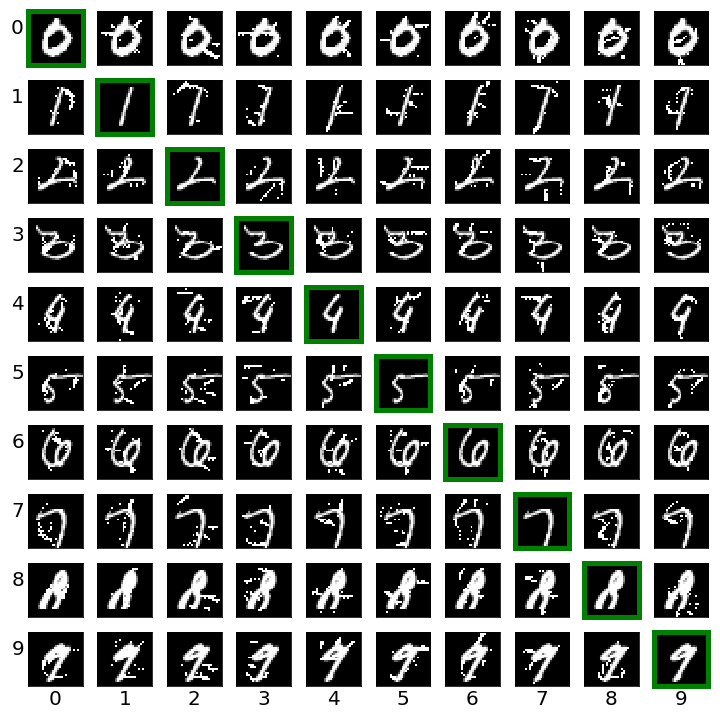

In [ ]:
gs.tight_layout(fig)
os.makedirs('img', exist_ok=True)
plt.savefig('img/jsma_mnist_10x10.png')
from IPython.display import Image
Image('img/jsma_mnist_10x10.png')